# Monet GAN - Style Transfer Competition

## Problem Description
This project tackles the Kaggle competition "I'm Something of a Painter Myself" where we'll build a Generative Adversarial Network (GAN) to create art in the style of Claude Monet.

### Objective
- Generate 7,000-10,000 Monet-style images (256x256 RGB)
- Train a GAN where:
  - Generator creates Monet-style images from photographs
  - Discriminator distinguishes between real Monet paintings and generated images

### Evaluation
- Performance measured by MiFID (Memorization-informed Fréchet Inception Distance)
- Lower scores = better results
- Penalizes direct memorization of training images

## Dataset
The dataset contains:
- Monet paintings (for training the discriminator)
- Photographs (to be transformed into Monet style)

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import zipfile
from IPython.display import clear_output

mixed_precision.set_global_policy('float32')

import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print(f"Numpy version: {np.__version__}")

TensorFlow version: 2.19.0
Keras version: 3.9.2
Numpy version: 2.1.3


In [8]:
monet_data_path = "data/monet_tfrec"
photo_data_path = "data/photo_tfrec"

print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  []


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.78039217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


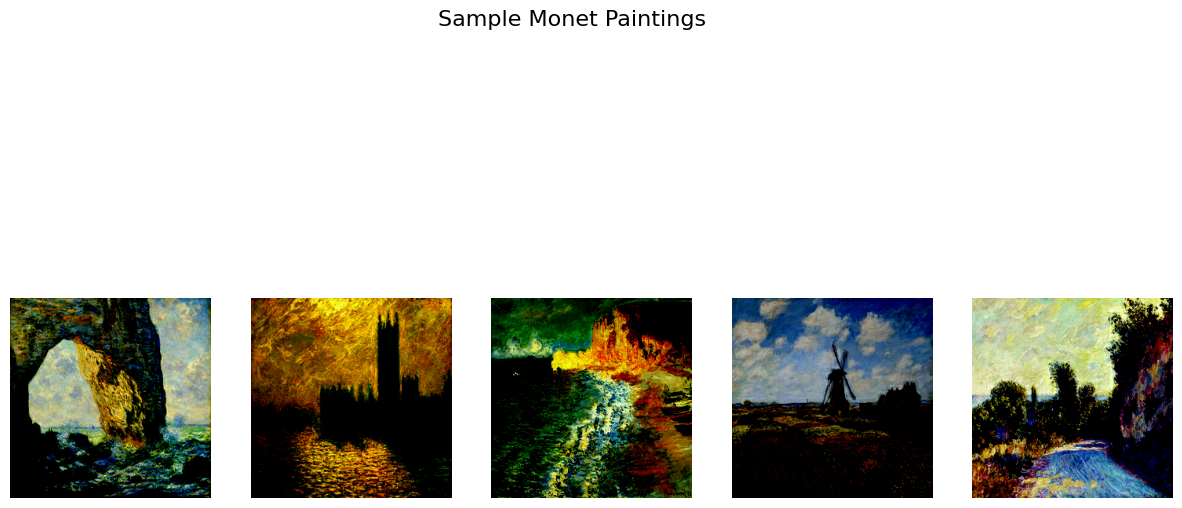

2025-04-13 00:50:57.935874: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


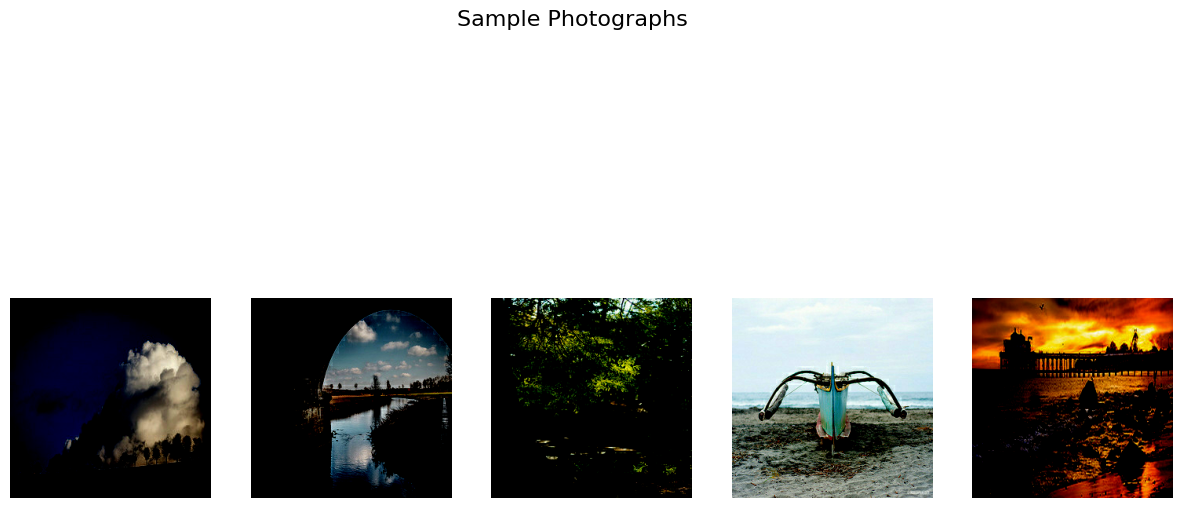

In [9]:
def parse_tfrecord(example):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'image_name': tf.io.FixedLenFeature([], tf.string)
    }
    
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    
    # Cast to float32 explicitly
    image = tf.cast(image, tf.float32) / 127.5 - 1.0
    image = tf.reshape(image, [256, 256, 3])
    
    # Ensure it's float32
    return tf.cast(image, tf.float32)

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Load datasets
monet_files = tf.io.gfile.glob('data/monet_tfrec/*.tfrec')
photo_files = tf.io.gfile.glob('data/photo_tfrec/*.tfrec')

monet_dataset = load_dataset(monet_files).take(5)
photo_dataset = load_dataset(photo_files).take(5)

def display_images(dataset, title):
    plt.figure(figsize=(15, 8))
    
    # Convert dataset to list to know the exact count
    images = list(dataset.as_numpy_iterator())
    num_images = len(images)
    
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.show()

display_images(monet_dataset, "Sample Monet Paintings")
display_images(photo_dataset, "Sample Photographs")

In [10]:
def analyze_image_stats(dataset, num_images=100):
    dataset = dataset.take(num_images)
    
    brightnesses = []
    contrasts = []
    color_means = {'r': [], 'g': [], 'b': []}
    color_stds = {'r': [], 'g': [], 'b': []}
    
    for image in dataset:
        # Calculate brightness (mean pixel value)
        brightnesses.append(tf.reduce_mean(image).numpy())
        
        # Calculate contrast (standard deviation of pixel values)
        contrasts.append(tf.math.reduce_std(image).numpy())
        
        # Calculate color channel statistics
        color_means['r'].append(tf.reduce_mean(image[:,:,0]).numpy())
        color_means['g'].append(tf.reduce_mean(image[:,:,1]).numpy())
        color_means['b'].append(tf.reduce_mean(image[:,:,2]).numpy())
        
        color_stds['r'].append(tf.math.reduce_std(image[:,:,0]).numpy())
        color_stds['g'].append(tf.math.reduce_std(image[:,:,1]).numpy())
        color_stds['b'].append(tf.math.reduce_std(image[:,:,2]).numpy())
    
    return {
        'brightness': {
            'mean': np.mean(brightnesses),
            'std': np.std(brightnesses)
        },
        'contrast': {
            'mean': np.mean(contrasts),
            'std': np.std(contrasts)
        },
        'color_means': {
            'r': np.mean(color_means['r']),
            'g': np.mean(color_means['g']),
            'b': np.mean(color_means['b'])
        },
        'color_stds': {
            'r': np.mean(color_stds['r']),
            'g': np.mean(color_stds['g']),
            'b': np.mean(color_stds['b'])
        }
    }

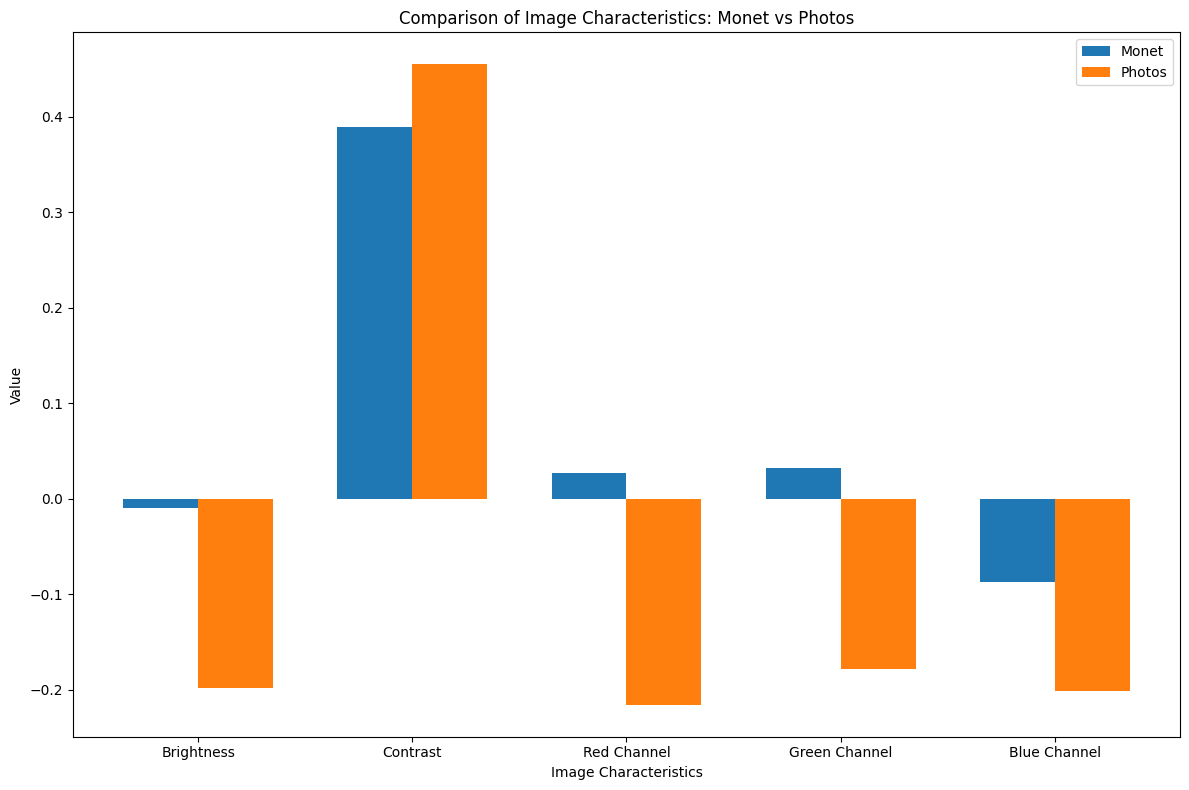

In [11]:
monet_analysis_dataset = load_dataset(monet_files).take(100)
photo_analysis_dataset = load_dataset(photo_files).take(100)

monet_stats = analyze_image_stats(monet_analysis_dataset)
photo_stats = analyze_image_stats(photo_analysis_dataset)

# Compare Monet vs Photos
stats_comparison = {
    'Brightness': [monet_stats['brightness']['mean'], photo_stats['brightness']['mean']],
    'Contrast': [monet_stats['contrast']['mean'], photo_stats['contrast']['mean']],
    'Red Channel': [monet_stats['color_means']['r'], photo_stats['color_means']['r']],
    'Green Channel': [monet_stats['color_means']['g'], photo_stats['color_means']['g']],
    'Blue Channel': [monet_stats['color_means']['b'], photo_stats['color_means']['b']],
}

# Plot comparison
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(stats_comparison))

bar1 = plt.bar(index, [v[0] for v in stats_comparison.values()], bar_width, label='Monet')
bar2 = plt.bar(index + bar_width, [v[1] for v in stats_comparison.values()], bar_width, label='Photos')

plt.xlabel('Image Characteristics')
plt.ylabel('Value')
plt.title('Comparison of Image Characteristics: Monet vs Photos')
plt.xticks(index + bar_width/2, stats_comparison.keys())
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def count_images(dataset):
    count = 0
    for _ in dataset:
        count += 1
    return count

monet_count = count_images(load_dataset(monet_files))
photo_count = count_images(load_dataset(photo_files))

print(f"Total Monet images: {monet_count}")
print(f"Total Photo images: {photo_count}")

In [ ]:
def plot_color_histograms(dataset, title, num_images=50):
    r_hist = np.zeros(256)
    g_hist = np.zeros(256)
    b_hist = np.zeros(256)
    
    for image in dataset.take(num_images):
        # Scale back to 0-255 range for histograms
        img_255 = tf.cast(image * 255, tf.int32).numpy()
        
        # Update histograms
        for i in range(256):
            r_hist[i] += np.sum(img_255[:,:,0] == i)
            g_hist[i] += np.sum(img_255[:,:,1] == i)
            b_hist[i] += np.sum(img_255[:,:,2] == i)
    
    # Normalize
    r_hist = r_hist / r_hist.sum()
    g_hist = g_hist / g_hist.sum()
    b_hist = b_hist / b_hist.sum()
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.bar(range(256), r_hist, color='red', alpha=0.7)
    plt.title('Red Channel')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    plt.bar(range(256), g_hist, color='green', alpha=0.7)
    plt.title('Green Channel')
    plt.xlabel('Pixel Value')
    
    plt.subplot(1, 3, 3)
    plt.bar(range(256), b_hist, color='blue', alpha=0.7)
    plt.title('Blue Channel')
    plt.xlabel('Pixel Value')
    
    plt.suptitle(f'Color Distribution: {title}', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_color_histograms(load_dataset(monet_files), "Monet Paintings")
plot_color_histograms(load_dataset(photo_files), "Photographs")

## Model Building and Training Strategy

### 1. Architecture: CycleGAN
CycleGAN is particularly well-suited for unpaired image-to-image translation between Monet paintings and photographs. The architecture consists of:

- **Two Generators**:
  - G_photo_to_monet: Transforms photos to Monet-style paintings
  - G_monet_to_photo: Transforms Monet paintings to photos (for cycle consistency)

- **Two Discriminators**:
  - D_monet: Determines if an image is a real Monet painting or generated
  - D_photo: Determines if an image is a real photo or generated

- **Key Feature**: Cycle consistency loss enforces that if we translate an image to the other domain and back, we should get the original image

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

BUFFER_SIZE = 1000
BATCH_SIZE = 4
IMG_WIDTH = 256
IMG_HEIGHT = 256
LAMBDA_CYCLE = 10
LAMBDA_IDENTITY = 0.5
EPOCHS = 20

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 127.5 - 1.0
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'image_name': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

monet_files = tf.io.gfile.glob('data/monet_tfrec/*.tfrec')
photo_files = tf.io.gfile.glob('data/photo_tfrec/*.tfrec')

monet_dataset = load_dataset(monet_files)
photo_dataset = load_dataset(photo_files)

monet_dataset = monet_dataset.take(300)
photo_dataset = photo_dataset.take(2000) #up to 5000

monet_dataset = monet_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
photo_dataset = photo_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

monet_viz_dataset = load_dataset(monet_files).take(5).batch(5)
photo_viz_dataset = load_dataset(photo_files).take(5).batch(5)

display_images(monet_viz_dataset.unbatch(), "Sample Monet Paintings")
display_images(photo_viz_dataset.unbatch(), "Sample Photographs")

In [53]:
# Define the Generator architecture (ResNet-based)
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = keras.Sequential()
    result.add(keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                   kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(keras.layers.BatchNormalization())
    
    result.add(keras.layers.LeakyReLU())
    
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = keras.Sequential()
    result.add(keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                           kernel_initializer=initializer, use_bias=False))
    
    result.add(keras.layers.BatchNormalization())
    
    if apply_dropout:
        result.add(keras.layers.Dropout(0.5))
    
    result.add(keras.layers.ReLU())
    
    return result

def Generator():
    inputs = keras.layers.Input(shape=[256, 256, 3], dtype=tf.float32)
    
    # Initial convolution
    x = keras.layers.Conv2D(32, 7, padding='same',  # Reduced from 64 to 32
                           kernel_initializer=tf.random_normal_initializer(0., 0.02),
                           use_bias=False)(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    
    # Downsampling (reduced filters)
    x = downsample(64, 3)(x)  # Reduced from 128 to 64
    
    # ResNet blocks (reduced number and size)
    for _ in range(3):  # Reduced from 9 to 3
        skip = x
        y = keras.layers.Conv2D(64, 3, padding='same',  # Reduced from 256 to 64
                              kernel_initializer=tf.random_normal_initializer(0., 0.02),
                              use_bias=False)(x)
        y = keras.layers.BatchNormalization()(y)
        y = keras.layers.ReLU()(y)
        y = keras.layers.Conv2D(64, 3, padding='same',  # Reduced from 256 to 64
                              kernel_initializer=tf.random_normal_initializer(0., 0.02),
                              use_bias=False)(y)
        y = keras.layers.BatchNormalization()(y)
        x = keras.layers.Add()([skip, y])
    
    # Upsampling (reduced filters)
    x = upsample(32, 3)(x)  # Reduced from 128 to 32
    
    # Final layer
    x = keras.layers.Conv2D(3, 7, padding='same',
                           kernel_initializer=tf.random_normal_initializer(0., 0.02),
                           activation='tanh')(x)
    
    return keras.Model(inputs=inputs, outputs=x)


# Define Discriminator (PatchGAN)
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], dtype=tf.float32, name='input_image')
    
    # Layer 1
    x = keras.layers.Conv2D(64, 4, strides=2, padding='same',
                           kernel_initializer=initializer)(inp)
    x = keras.layers.LeakyReLU(0.2)(x)
    
    # Layer 2
    x = keras.layers.Conv2D(128, 4, strides=2, padding='same',
                           kernel_initializer=initializer, use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(0.2)(x)
    
    # Layer 3
    x = keras.layers.Conv2D(256, 4, strides=2, padding='same',
                           kernel_initializer=initializer, use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(0.2)(x)
    
    # Layer 4
    x = keras.layers.Conv2D(512, 4, strides=1, padding='same',
                           kernel_initializer=initializer, use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(0.2)(x)
    
    # Final layer - no sigmoid (for use with least squares loss)
    x = keras.layers.Conv2D(1, 4, strides=1, padding='same',
                           kernel_initializer=initializer)(x)
    
    return keras.Model(inputs=inp, outputs=x)

In [54]:
# Instantiate models
generator_photo_to_monet = Generator()
generator_monet_to_photo = Generator()
discriminator_monet = Discriminator()
discriminator_photo = Discriminator()

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_loss = real_loss + generated_loss
    return total_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    real_image = tf.cast(real_image, tf.float32)
    cycled_image = tf.cast(cycled_image, tf.float32)
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA_CYCLE * loss

def identity_loss(real_image, same_image):
    real_image = tf.cast(real_image, tf.float32)
    same_image = tf.cast(same_image, tf.float32)
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA_IDENTITY * loss


generator_photo_to_monet_opt = keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_monet_to_photo_opt = keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_monet_opt = keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_photo_opt = keras.optimizers.Adam(2e-4, beta_1=0.5)

# Checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_photo_to_monet=generator_photo_to_monet,
    generator_monet_to_photo=generator_monet_to_photo,
    discriminator_monet=discriminator_monet,
    discriminator_photo=discriminator_photo,
    generator_photo_to_monet_opt=generator_photo_to_monet_opt,
    generator_monet_to_photo_opt=generator_monet_to_photo_opt,
    discriminator_monet_opt=discriminator_monet_opt,
    discriminator_photo_opt=discriminator_photo_opt)

In [55]:
tf.config.run_functions_eagerly(True)

def train_step(real_monet, real_photo):
    start_time = time.time()
    with tf.GradientTape(persistent=True) as tape:
        fake_monet = generator_photo_to_monet(real_photo, training=True)
        fake_photo = generator_monet_to_photo(real_monet, training=True)
        
        cycled_monet = generator_photo_to_monet(fake_photo, training=True)
        cycled_photo = generator_monet_to_photo(fake_monet, training=True)
        
        same_monet = generator_photo_to_monet(real_monet, training=True)
        same_photo = generator_monet_to_photo(real_photo, training=True)
        
        disc_real_monet = discriminator_monet(real_monet, training=True)
        disc_fake_monet = discriminator_monet(fake_monet, training=True)
        
        disc_real_photo = discriminator_photo(real_photo, training=True)
        disc_fake_photo = discriminator_photo(fake_photo, training=True)
        
        gen_monet_loss = generator_loss(disc_fake_monet)
        gen_photo_loss = generator_loss(disc_fake_photo)
        
        cycle_monet_loss = calc_cycle_loss(real_monet, cycled_monet)
        cycle_photo_loss = calc_cycle_loss(real_photo, cycled_photo)
        total_cycle_loss = cycle_monet_loss + cycle_photo_loss
        
        identity_monet_loss = identity_loss(real_monet, same_monet)
        identity_photo_loss = identity_loss(real_photo, same_photo)
        
        total_gen_monet_loss = gen_monet_loss + total_cycle_loss + identity_monet_loss
        total_gen_photo_loss = gen_photo_loss + total_cycle_loss + identity_photo_loss
        
        disc_monet_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        disc_photo_loss = discriminator_loss(disc_real_photo, disc_fake_photo)
    
    # Calculate gradients
    generator_monet_gradients = tape.gradient(total_gen_monet_loss, 
                                             generator_photo_to_monet.trainable_variables)
    generator_photo_gradients = tape.gradient(total_gen_photo_loss, 
                                            generator_monet_to_photo.trainable_variables)
    
    discriminator_monet_gradients = tape.gradient(disc_monet_loss, 
                                                discriminator_monet.trainable_variables)
    discriminator_photo_gradients = tape.gradient(disc_photo_loss, 
                                                discriminator_photo.trainable_variables)
    
    # Apply gradients with the separate optimizers
    generator_photo_to_monet_opt.apply_gradients(zip(generator_monet_gradients, 
                                              generator_photo_to_monet.trainable_variables))
    generator_monet_to_photo_opt.apply_gradients(zip(generator_photo_gradients, 
                                              generator_monet_to_photo.trainable_variables))
    
    discriminator_monet_opt.apply_gradients(zip(discriminator_monet_gradients,
                                            discriminator_monet.trainable_variables))
    discriminator_photo_opt.apply_gradients(zip(discriminator_photo_gradients,
                                            discriminator_photo.trainable_variables))
    
    print(f"Real monet range: {tf.reduce_min(real_monet)} to {tf.reduce_max(real_monet)}")
    print(f"Fake monet range: {tf.reduce_min(fake_monet)} to {tf.reduce_max(fake_monet)}")
    
    end_time = time.time()
    
    return {
        'gen_monet_loss': total_gen_monet_loss,
        'gen_photo_loss': total_gen_photo_loss,
        'disc_monet_loss': disc_monet_loss,
        'disc_photo_loss': disc_photo_loss,
        'step_time': end_time - start_time
    }

In [56]:
def generate_images(model, test_input_batch):
    # Take the first image from the batch for visualization
    test_input = test_input_batch[0:1]  # Keep batch dimension, just use first image
    prediction = model(test_input, training=False)
    
    plt.figure(figsize=(12, 6))
    
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Generated Image']
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        
        plt.imshow(display_list[i] * 0.5 + 0.5) 
        plt.axis('off')
    plt.show()

# training loop with progress tracking
def fit(monet_dataset, photo_dataset, epochs):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
        
    for epoch in range(epochs):
        start = time.time()
        import psutil
        process = psutil.Process()
        memory_info = process.memory_info()
        memory_usage_gb = memory_info.rss / 1024 / 1024 / 1024
        print(f"Memory usage: {memory_usage_gb:.2f} GB")

        print(f"Epoch {epoch+1}/{epochs}")
        
        epoch_gen_monet_losses = []
        epoch_gen_photo_losses = []
        epoch_disc_monet_losses = []
        epoch_disc_photo_losses = []
        
        dataset_length = tf.data.experimental.cardinality(
            tf.data.Dataset.zip((monet_dataset, photo_dataset))).numpy()
        
        for batch_idx, (monet_batch, photo_batch) in enumerate(
                tf.data.Dataset.zip((monet_dataset, photo_dataset))):
            
            losses = train_step(monet_batch, photo_batch)
            
            epoch_gen_monet_losses.append(losses['gen_monet_loss'])
            epoch_gen_photo_losses.append(losses['gen_photo_loss'])
            epoch_disc_monet_losses.append(losses['disc_monet_loss'])
            epoch_disc_photo_losses.append(losses['disc_photo_loss'])
            
            if batch_idx % 5 == 0:
                print(f"Batch {batch_idx}/{dataset_length} - ", end="")
                print(f"G_m: {losses['gen_monet_loss']:.4f}, ", end="")
                print(f"G_p: {losses['gen_photo_loss']:.4f}, ", end="")
                print(f"D_m: {losses['disc_monet_loss']:.4f}, ", end="")
                print(f"D_p: {losses['disc_photo_loss']:.4f}")
        
        clear_output(wait=True)
        
        # Show sample images and losses
        for inp in photo_dataset.take(1):
            generate_images(generator_photo_to_monet, inp)
        
        # Plot losses
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(epoch_gen_monet_losses, label='Generator Photo->Monet Loss')
        plt.plot(epoch_gen_photo_losses, label='Generator Monet->Photo Loss')
        plt.legend()
        plt.title(f'Generator Losses - Epoch {epoch+1}')
        
        plt.subplot(1, 2, 2)
        plt.plot(epoch_disc_monet_losses, label='Discriminator Monet Loss')
        plt.plot(epoch_disc_photo_losses, label='Discriminator Photo Loss')
        plt.legend()
        plt.title(f'Discriminator Losses - Epoch {epoch+1}')
        
        plt.show()
        
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f"Checkpoint saved at epoch {epoch+1}")
        
        print(f'Time taken for epoch {epoch+1}: {time.time()-start:.2f} sec')

In [ ]:
def generate_images_for_submission(generator, dataset, output_dir, num_images=7000):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    count = 0
    for batch in dataset:
        predictions = generator(batch, training=False)
        
        for i, pred in enumerate(predictions):
            pred = (pred * 0.5 + 0.5) * 255
            pred = tf.cast(pred, tf.uint8)
            
            encoded_image = tf.image.encode_jpeg(pred)
            
            img_path = os.path.join(output_dir, f'generated_{count:04d}.jpg')
            tf.io.write_file(img_path, encoded_image)
            
            count += 1
            if count % 100 == 0:
                print(f'Generated {count} images')
            
            if count >= num_images:
                return

In [ ]:
fit(monet_dataset, photo_dataset, EPOCHS)

In [ ]:
unbatched_photo_dataset = load_dataset(photo_files).take(7500)
photo_dataset_for_gen = unbatched_photo_dataset.batch(4)

output_dir = './generated_images'
generate_images_for_submission(generator_photo_to_monet, photo_dataset_for_gen, output_dir)

with zipfile.ZipFile('images.zip', 'w') as zf:
    for img_file in os.listdir(output_dir):
        zf.write(os.path.join(output_dir, img_file), arcname=img_file)

print('Submission file "images.zip" created!')